# Neural Analysis Demo

This notebook demonstrates:
- Distance calculations (pairwise, within/between distributions)
- Distribution comparison metrics
- Outlier detection methods (IQR, Z-score, LOF, Isolation Forest, Elliptic)
- Visualizations using the built-in plotting utilities

---

## Table of Contents
1. [Setup and Data Generation](#setup)
2. [Distance Calculations](#distances)
3. [Distribution Comparison](#distributions)
4. [Outlier Detection](#outliers)
5. [Similarity Analysis](#similarity)
6. [Performance Benchmarking](#performance)

In [14]:
# Imports
import numpy as np
import time

# Import from metrics submodules directly to avoid kernel cache issues
from neural_analysis.metrics.distance import (
    pairwise_distance,
    distribution_distance,
)
from neural_analysis.metrics.distributions import compare_distributions
from neural_analysis.metrics.outliers import filter_outlier
from neural_analysis.metrics.similarity import similarity_matrix

from neural_analysis.plotting import (
    set_backend,
    PlotConfig,
    plot_grouped_scatter_2d,
    plot_kde_2d,
    plot_line,
    plot_heatmap,
    create_subplot_grid,
)

# Use matplotlib for static plots in this demo
set_backend('matplotlib')

<a id='setup'></a>
## 1. Setup and Data Generation

In [15]:
# Generate synthetic 2D datasets (A and B) with known structure
np.random.seed(42)

n_per_group = 200
mean_A = np.array([0.0, 0.0])
mean_B = np.array([2.0, 1.0])
cov = np.array([[1.0, 0.3],[0.3, 0.8]])

A = np.random.multivariate_normal(mean_A, cov, size=n_per_group)
B = np.random.multivariate_normal(mean_B, cov, size=n_per_group)

# Inject a few strong outliers into B
outliers = np.random.randn(8, 2) * 6 + np.array([6.0, -6.0])
B_with_outliers = np.vstack([B, outliers])

print(f"A shape: {A.shape}, B shape: {B.shape}, B_with_outliers: {B_with_outliers.shape}")


A shape: (200, 2), B shape: (200, 2), B_with_outliers: (208, 2)


<Axes: title={'center': 'Grouped scatter: A vs B'}, xlabel='X', ylabel='Y'>

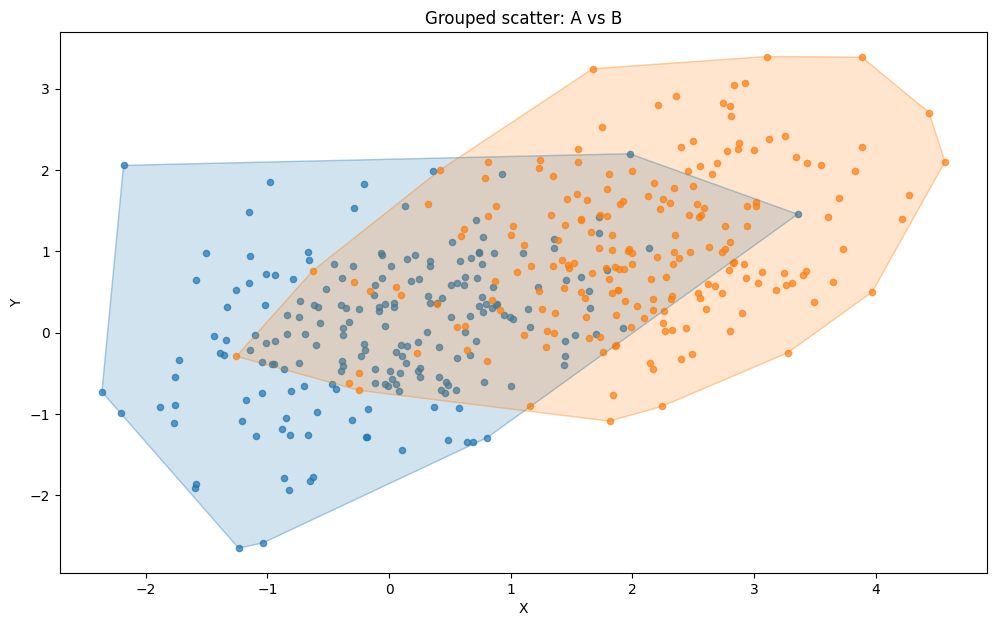

In [3]:
# Visualize distributions A and B (grouped scatter)
config = PlotConfig(title="Grouped scatter: A vs B", xlabel="X", ylabel="Y", show=True)
plot_grouped_scatter_2d({"A": (A[:,0], A[:,1]), "B": (B[:,0], B[:,1])}, config=config)


<a id='distances'></a>
## 2. Distance Calculations

Pairwise distance matrix shape: (50, 50)
Within A: {'mean': 1.596818781121446, 'std': 0.8767854730135421, 'median': 1.4717597869283665, 'min': 0.01165120536327024, 'max': 6.160976839519321}
Within B: {'mean': 1.681182932584051, 'std': 0.9155919730332672, 'median': 1.5522060823715624, 'min': 0.002786294193343759, 'max': 6.432507936266354}
Between A and B: {'mean': 2.6798188451290286, 'std': 1.2870787689176604, 'median': 2.5854354539814794, 'min': 0.011907837226573148, 'max': 7.915453799566353}


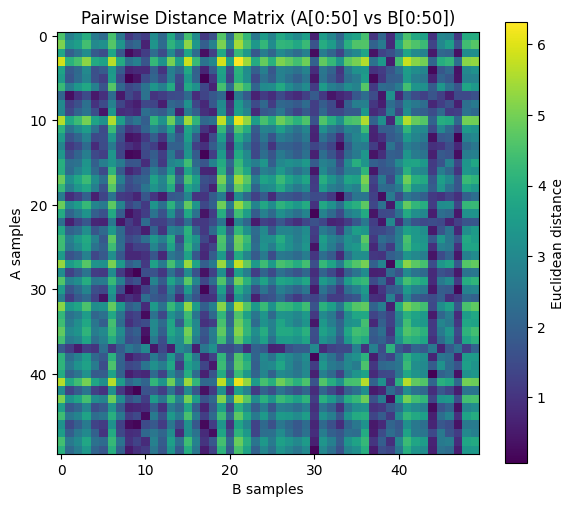

In [12]:
# Distance calculations: pairwise and summaries
# Pairwise Euclidean distance between subsets (for visualization and scale)
X = A[:50]
Y = B[:50]
D = pairwise_distance(X, Y, metric="euclidean")
print("Pairwise distance matrix shape:", D.shape)

# Show a quick heatmap of the pairwise distances using PlotGrid system
config = PlotConfig(
    title='Pairwise Distance Matrix (A[0:50] vs B[0:50])',
    xlabel='B samples',
    ylabel='A samples',
    figsize=(6, 5),
    show=True
)
plot_heatmap(
    D,
    config=config,
    cmap='viridis',
    colorbar=True,
    colorbar_label='Euclidean distance',
    backend='matplotlib'
)

# Within and between distribution summaries
within_A = distribution_distance(A, mode="within", metric="euclidean", summary="all")
within_B = distribution_distance(B, mode="within", metric="euclidean", summary="all")
between_AB = distribution_distance(A, B, mode="between", metric="euclidean", summary="all")

print("Within A:", within_A)
print("Within B:", within_B)
print("Between A and B:", between_AB)


         wasserstein: 3.0938
  kolmogorov-smirnov: 0.7500
      jensen-shannon: 0.6407
           euclidean: 2.3160
              cosine: -0.3833


<Axes: title={'center': 'KDE of Combined A and B'}, xlabel='X', ylabel='Y'>

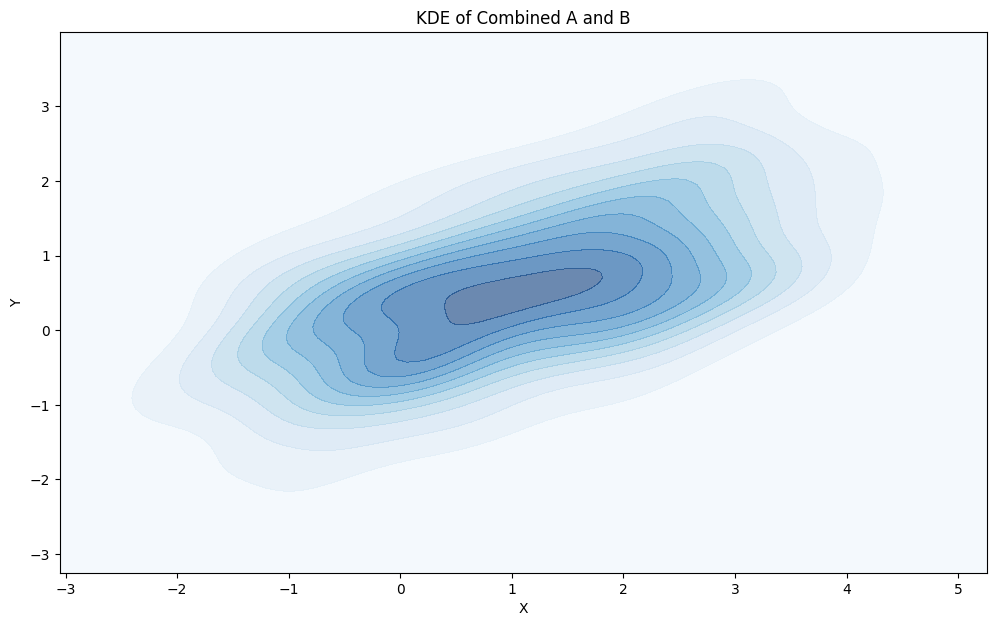

In [5]:
# Distribution comparison metrics
metrics = ["wasserstein", "kolmogorov-smirnov", "jensen-shannon", "euclidean", "cosine"]
results = {}
for m in metrics:
    results[m] = compare_distributions(A, B, metric=m)

for m, v in results.items():
    print(f"{m:>20}: {v:.4f}")

# Show KDE overlay of combined distributions to visualize overlap
config = PlotConfig(title="KDE of Combined A and B", xlabel="X", ylabel="Y", show=True)
plot_kde_2d(np.concatenate([A[:,0], B[:,0]]), np.concatenate([A[:,1], B[:,1]]), config=config, show_points=False)


<a id='distributions'></a>
## 3. Distribution Comparison


Remaining points after filtering:
      Original: 208
           iqr: 200 remaining ( 8 removed,   3.8%)
        zscore: 199 remaining ( 9 removed,   4.3%)
           lof: 197 remaining (11 removed,   5.3%)
     isolation: 197 remaining (11 removed,   5.3%)
      elliptic: 197 remaining (11 removed,   5.3%)


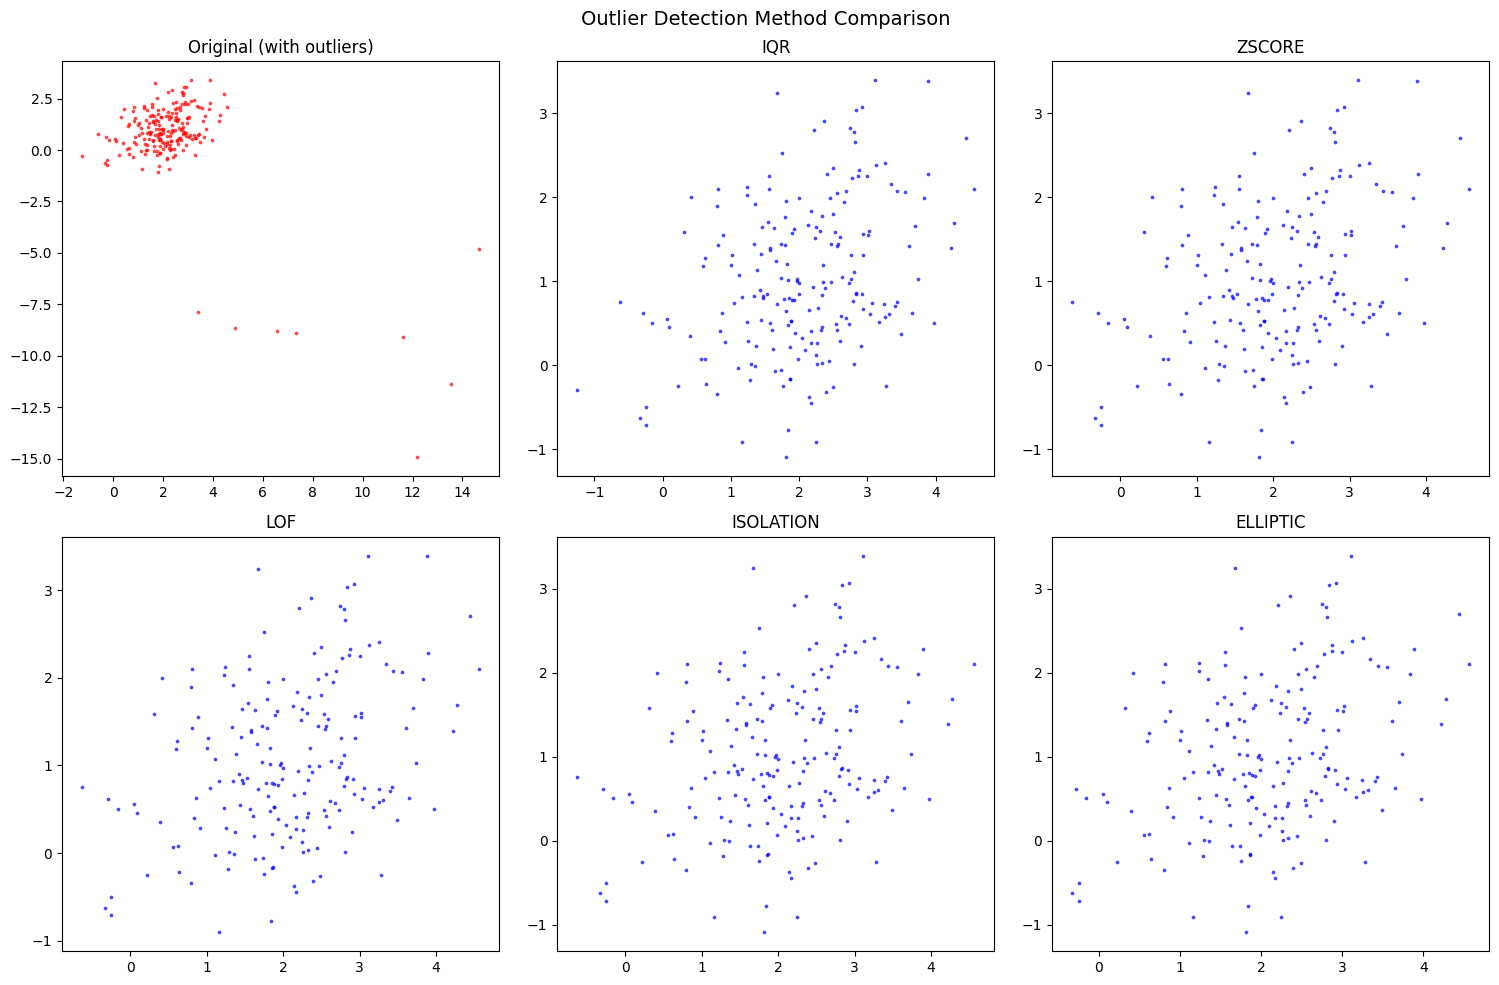

In [16]:
# Outlier detection: compare methods on B_with_outliers using subplot grid
from neural_analysis.plotting import PlotSpec

# Apply different methods
methods = ["iqr", "zscore", "lof", "isolation", "elliptic"]
filtered_counts = {}
plot_specs = []

# First, add the original data with outliers
plot_specs.append(PlotSpec(
    data=np.column_stack([B_with_outliers[:,0], B_with_outliers[:,1]]),
    plot_type='scatter',
    title='Original (with outliers)',
    subplot_position=0,
    color='red',
    marker_size=3,
    alpha=0.6
))

# Apply each method and create plot specs
for idx, method in enumerate(methods):
    filtered = filter_outlier(B_with_outliers, method=method, contamination=0.05, threshold=3.0)
    filtered_counts[method] = filtered.shape[0]
    
    plot_specs.append(PlotSpec(
        data=np.column_stack([filtered[:,0], filtered[:,1]]),
        plot_type='scatter',
        title=f'{method.upper()}',
        subplot_position=idx + 1,
        color='blue',
        marker_size=3,
        alpha=0.6
    ))

# Create subplot grid (2 rows x 3 columns)
from neural_analysis.plotting import PlotGrid, GridLayoutConfig

grid = PlotGrid(
    plot_specs=plot_specs,
    config=PlotConfig(
        title="Outlier Detection Method Comparison",
        figsize=(15, 10)
    ),
    layout=GridLayoutConfig(rows=2, cols=3),
    backend='matplotlib'
)

fig = grid.plot()

# Print summary
print("\nRemaining points after filtering:")
print(f"  {'Original':>12}: {B_with_outliers.shape[0]}")
for m, c in filtered_counts.items():
    removed = B_with_outliers.shape[0] - c
    removed_pct = (removed / B_with_outliers.shape[0]) * 100
    print(f"  {m:>12}: {c:>3} remaining ({removed:>2} removed, {removed_pct:>5.1f}%)")

<a id='outliers'></a>
## 4. Outlier Detection

Compare different outlier detection methods on data with injected outliers.

Correlation matrix (combined A and B across 4 dimensions):
[[ 1.     0.337 -0.182 -0.033]
 [ 0.337  1.     0.025 -0.026]
 [-0.182  0.025  1.     0.347]
 [-0.033 -0.026  0.347  1.   ]]


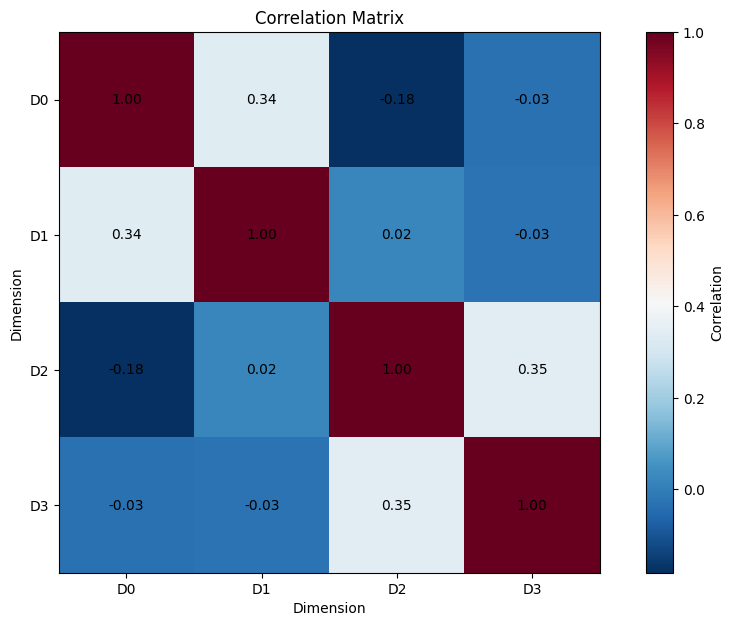

In [ ]:
# Compute correlation matrix and visualize
# Combine A and B to see correlations between dimensions
combined = np.hstack([A, B])  # shape: (200, 4)

# Compute Pearson correlation
corr = similarity_matrix(combined, method='pearson')
print("Correlation matrix (combined A and B across 4 dimensions):")
print(corr.round(3))

# Visualize as heatmap
fig = plot_heatmap(
    corr,
    config=PlotConfig(title="Correlation Matrix", xlabel="Dimension", ylabel="Dimension"),
    x_labels=[f"D{i}" for i in range(4)],
    y_labels=[f"D{i}" for i in range(4)],
    cmap='RdBu_r',
    show_values=True,
    value_format='.2f',
    colorbar_label="Correlation",
    backend='matplotlib'
)

<a id='similarity'></a>
## 5. Similarity Analysis

Running performance benchmarks on 5000x50 data...
------------------------------------------------------------
         iqr:  0.006s
      zscore:  0.006s
         lof:  0.031s
   isolation:  0.124s
    elliptic:  4.782s
------------------------------------------------------------
    elliptic:  4.782s
------------------------------------------------------------


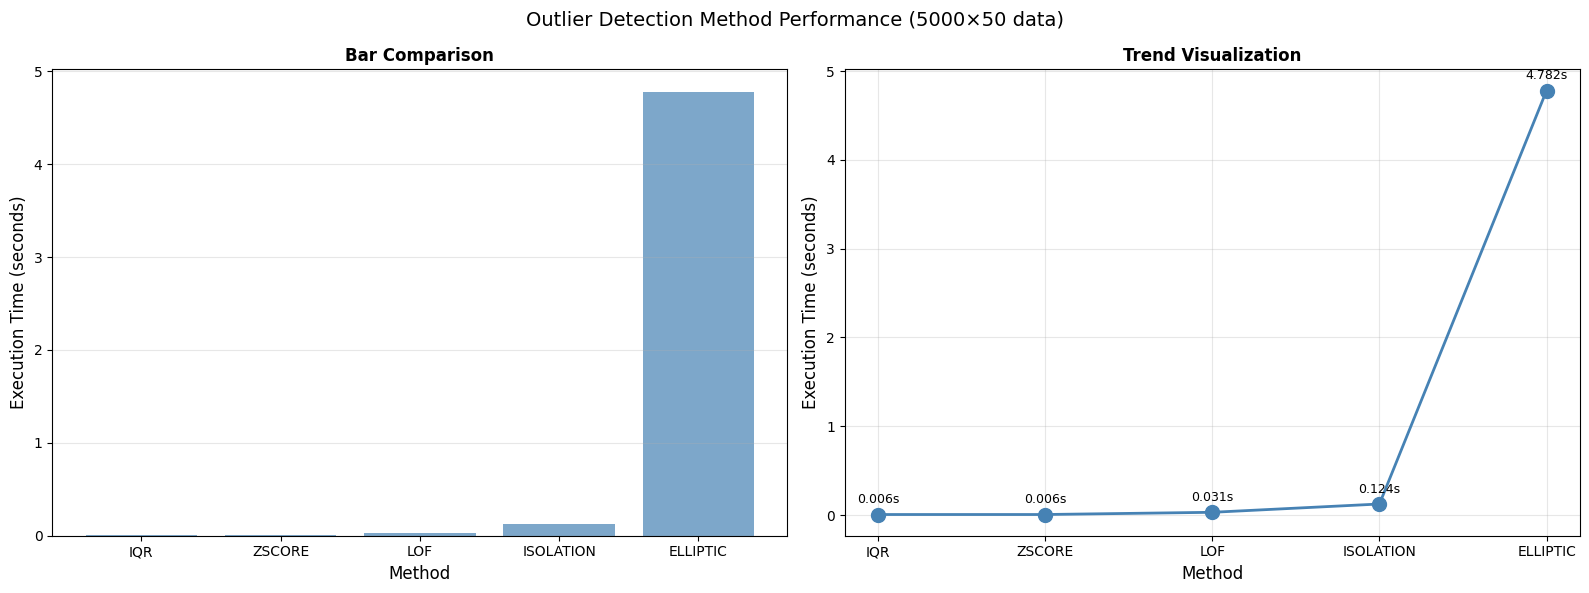


Performance Insights:
  Fastest: IQR (0.006s)
  Slowest: ELLIPTIC (4.782s)
  Speedup: 848.7x


In [19]:
# Performance comparison: compare timing of all outlier detection methods
import time

# Generate high-dimensional test data
np.random.seed(123)
X_hd = np.random.randn(5000, 50)
X_hd[:100] += 5.0  # inject outliers

# Methods to compare
methods_to_test = ["iqr", "zscore", "lof", "isolation", "elliptic"]
timings = {}

print("Running performance benchmarks on 5000x50 data...")
print("-" * 60)

for method in methods_to_test:
    start = time.time()
    _ = filter_outlier(X_hd, method=method, contamination=0.02, return_mask=False)
    elapsed = time.time() - start
    timings[method] = elapsed
    print(f"{method:>12}: {elapsed:>6.3f}s")

print("-" * 60)

# Create visualizations using the PlotGrid system
from neural_analysis.plotting import PlotSpec, PlotGrid, GridLayoutConfig

method_names = [m.upper() for m in methods_to_test]
times = [timings[m] for m in methods_to_test]

# Create subplot grid with bar plot and line plot side by side
plot_specs = []

# Bar plot specs (left subplot) - one spec per bar
for idx, (name, time_val) in enumerate(zip(method_names, times)):
    plot_specs.append(PlotSpec(
        data=np.array([time_val]),
        plot_type='bar',
        subplot_position=0,
        color='steelblue',
        alpha=0.7,
        kwargs={'x': [idx]}
    ))

# Line plot (right subplot)
plot_specs.append(PlotSpec(
    data=np.column_stack([np.arange(len(times)), times]),
    plot_type='line',
    subplot_position=1,
    color='steelblue',
    line_width=2,
    marker='o',
    marker_size=10,
    alpha=1.0
))

# Create the grid
grid = PlotGrid(
    plot_specs=plot_specs,
    config=PlotConfig(
        title="Outlier Detection Method Performance (5000×50 data)",
        figsize=(16, 6)
    ),
    layout=GridLayoutConfig(rows=1, cols=2),
    backend='matplotlib'
)

result = grid.plot()

# Handle the return value - PlotGrid returns (fig, axes) tuple for matplotlib
import matplotlib.pyplot as plt
if isinstance(result, tuple):
    fig, axes = result
else:
    fig = result
    axes = fig.axes

# Customize the axes
# Left subplot (bar plot)
axes[0].set_xlabel('Method', fontsize=12)
axes[0].set_ylabel('Execution Time (seconds)', fontsize=12)
axes[0].set_title('Bar Comparison', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(len(method_names)))
axes[0].set_xticklabels(method_names)
axes[0].grid(True, alpha=0.3, axis='y')

# Right subplot (line plot)
axes[1].set_xlabel('Method', fontsize=12)
axes[1].set_ylabel('Execution Time (seconds)', fontsize=12)
axes[1].set_title('Trend Visualization', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(len(method_names)))
axes[1].set_xticklabels(method_names)
axes[1].grid(True, alpha=0.3)
# Add value labels on points
for i, (name, time_val) in enumerate(zip(method_names, times)):
    axes[1].text(i, time_val + max(times) * 0.02, f'{time_val:.3f}s', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print performance insights
print("\nPerformance Insights:")
fastest = min(timings, key=timings.get)
slowest = max(timings, key=timings.get)
print(f"  Fastest: {fastest.upper()} ({timings[fastest]:.3f}s)")
print(f"  Slowest: {slowest.upper()} ({timings[slowest]:.3f}s)")
print(f"  Speedup: {timings[slowest]/timings[fastest]:.1f}x")

<a id='performance'></a>
## 6. Performance Benchmarking

Compare execution time of different outlier detection methods on high-dimensional data.

# Summary

## What We Demonstrated
- Computed pairwise and summary distances using unified `distribution_distance()` API
- Applied multiple distribution comparison metrics with `compare_distributions()`
- Detected outliers with several methods using `filter_outlier()`
- Visualized data and results with modular plotting utilities

## Quick Reference: When to Use Each Method

### Distance Metrics

**Choose based on your data structure:**
- **Euclidean**: Default choice for spherical clusters, equal feature importance
- **Mahalanobis**: Use when features are correlated or clusters are elongated
- **Cosine**: Use when direction matters more than magnitude (e.g., high-dimensional sparse data)

**Example scenarios:**
- Neural population state space (uncorrelated): Euclidean
- Elongated trajectory in low-dimensional manifold: Mahalanobis  
- Comparing tuning curves or sparse firing patterns: Cosine

### Distribution Comparison

**Choose based on what you want to measure:**
- **Wasserstein**: Best for quantifying geometric displacement between distributions
- **Kolmogorov-Smirnov**: Fast hypothesis testing, detects any distributional difference
- **Jensen-Shannon**: Symmetric probability divergence, good for general comparison
- **Euclidean/Cosine (on means)**: Quick centroid-based comparison

**Example scenarios:**
- How much did neural activity "shift" between conditions?: Wasserstein
- Are two trial groups from the same distribution?: K-S test
- General similarity between firing rate distributions?: Jensen-Shannon
- Quick check if population means differ?: Euclidean (means)

### Outlier Detection

**Choose based on data dimensionality and structure:**
- **IQR/Z-Score**: Low-dimensional (1-3D), interpretable thresholds
- **Isolation Forest**: High-dimensional (>10D), complex structures, fast
- **LOF**: Varying density clusters, local anomalies
- **Elliptic Envelope**: Correlated Gaussian data, accounts for covariance

**Example scenarios:**
- Detecting bad trials in single neuron firing rate: IQR
- Removing artifacts from high-dimensional neural recordings: Isolation Forest
- Finding unusual patterns in heterogeneous population activity: LOF
- Cleaning multivariate Gaussian-distributed neural features: Elliptic Envelope

## Next Steps

- See `examples/metrics_examples.ipynb` for comprehensive ground truth validation
- Check `docs/project_goal.md` for architecture and design decisions
- Explore `src/neural_analysis/plotting/` for more visualization options

Feel free to adapt this notebook for your own datasets and analysis needs!